In [1]:
%pylab inline
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils.np_utils import to_categorical

Populating the interactive namespace from numpy and matplotlib


/Users/matt/.virtualenvs/kaggle/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [2]:
train = pd.read_csv('train.csv')
train_labels = train.species
train = train.drop(['species', 'id'], axis=1)

test = pd.read_csv('test.csv').drop(['id'], axis=1)

In [3]:
## Encoding the textual labels categorically and normalize them such that 
## they contain only values between 0 and n_classes-1. 
label_encoder = LabelEncoder().fit(train_labels)
train_labels = label_encoder.transform(train_labels) 
classes = list(label_encoder.classes_)

In [4]:
## Standardising the data to give zero mean
## This seems to be very important
train = StandardScaler().fit(train).transform(train)
test = StandardScaler().fit(test).transform(test)

In [5]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=23)
for train_index, valid_index in sss.split(train, train_labels):
    
    ## FIXME isn't this just throwing away the first n-1 splits??
    
    X_train, X_valid = train[train_index], train[valid_index]
    y_train, y_valid = train_labels[train_index], train_labels[valid_index]
    
## Working with categorical crossentropy function, so converting the labels into "one-hot" representation
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [6]:
model = Sequential()
model.add(Dense(1024,input_dim=X_train.shape[1])) # 192
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Activation('sigmoid'))
model.add(Dense(size(classes))) # 99
model.add(Activation('softmax'))

total_epochs = 100

def print_results(epoch, logs):
    if epoch % 5 == 0 or epoch == total_epochs - 1:
        f = 'epoch {:3d} | train acc: {:.4f}, train loss: {:.4f}, val acc: {:.4f}, val loss: {:.4f}'
        print(f.format(epoch, logs['acc'], logs['loss'], logs['val_acc'], logs['val_loss']))
        
cb = keras.callbacks.LambdaCallback(on_epoch_end=print_results)

rms = keras.optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=rms, metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    nb_epoch=total_epochs, 
                    validation_data=(X_valid, y_valid), 
                    verbose=0, 
                    callbacks=[cb])

epoch   0 | train acc: 0.0157, train loss: 4.7778, val acc: 0.0808, val loss: 4.3052
epoch   5 | train acc: 0.4299, train loss: 3.1795, val acc: 0.6162, val loss: 2.7405
epoch  10 | train acc: 0.7767, train loss: 2.0407, val acc: 0.8384, val loss: 1.5541
epoch  15 | train acc: 0.9214, train loss: 1.2142, val acc: 0.9394, val loss: 0.8191
epoch  20 | train acc: 0.9607, train loss: 0.6813, val acc: 0.9596, val loss: 0.4246
epoch  25 | train acc: 0.9910, train loss: 0.3636, val acc: 0.9495, val loss: 0.2661
epoch  30 | train acc: 0.9944, train loss: 0.1938, val acc: 0.9697, val loss: 0.1696
epoch  35 | train acc: 0.9955, train loss: 0.1048, val acc: 0.9798, val loss: 0.1335
epoch  40 | train acc: 0.9978, train loss: 0.0571, val acc: 0.9899, val loss: 0.1018
epoch  45 | train acc: 1.0000, train loss: 0.0275, val acc: 0.9798, val loss: 0.1002
epoch  50 | train acc: 1.0000, train loss: 0.0158, val acc: 0.9798, val loss: 0.0916
epoch  55 | train acc: 1.0000, train loss: 0.0080, val acc: 0.979

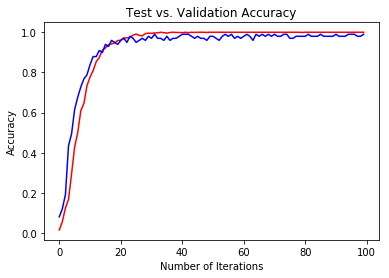

In [7]:
plt.plot(history.history['acc'], 'r', history.history['val_acc'], 'b')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Test vs. Validation Accuracy')

In [8]:
# test = pd.read_csv('test.csv')
# index = test.pop('id')
# test = StandardScaler().fit(test).transform(test)
# yPred = model.predict_proba(test)

## Converting the test predictions in a dataframe as depicted by sample submission
# yPred = pd.DataFrame(yPred,index=index,columns=sort(parent_data.species.unique()))

# fp = open('submission_nn_kernel.csv','w')
# fp.write(yPred.to_csv())